In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path = Path('data/train').absolute()
path.ls()

[PosixPath('/home/lgvaz/projects/vision/carvana-cars/data/train/train_masks.csv'),
 PosixPath('/home/lgvaz/projects/vision/carvana-cars/data/train/labels'),
 PosixPath('/home/lgvaz/projects/vision/carvana-cars/data/train/original'),
 PosixPath('/home/lgvaz/projects/vision/carvana-cars/data/train/tiny'),
 PosixPath('/home/lgvaz/projects/vision/carvana-cars/data/train/train_hq.zip')]

In [4]:
path_img = path/'original'
path_lbl = path/'labels'

In [5]:
img_f = path_img.ls()[0]

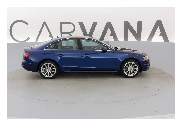

In [6]:
img = open_image(img_f)
img.show()

In [7]:
get_y_fn = lambda x: path_lbl/f'{x.stem}.png'

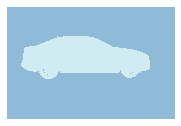

In [8]:
mask = open_mask(get_y_fn(img_f))
mask.show()

In [9]:
src_size = np.array(mask.shape[1:]); src_size

array([1280, 1918])

In [10]:
size = src_size//12
bs = 32
size

array([106, 159])

In [11]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct(0.2, seed=42)
       .label_from_func(get_y_fn, classes=[0, 'car']))

In [12]:
data = (src
        .transform(get_transforms(), tfm_y=True, size=size)
        .databunch(bs=bs, num_workers=16)
        .normalize(imagenet_stats))

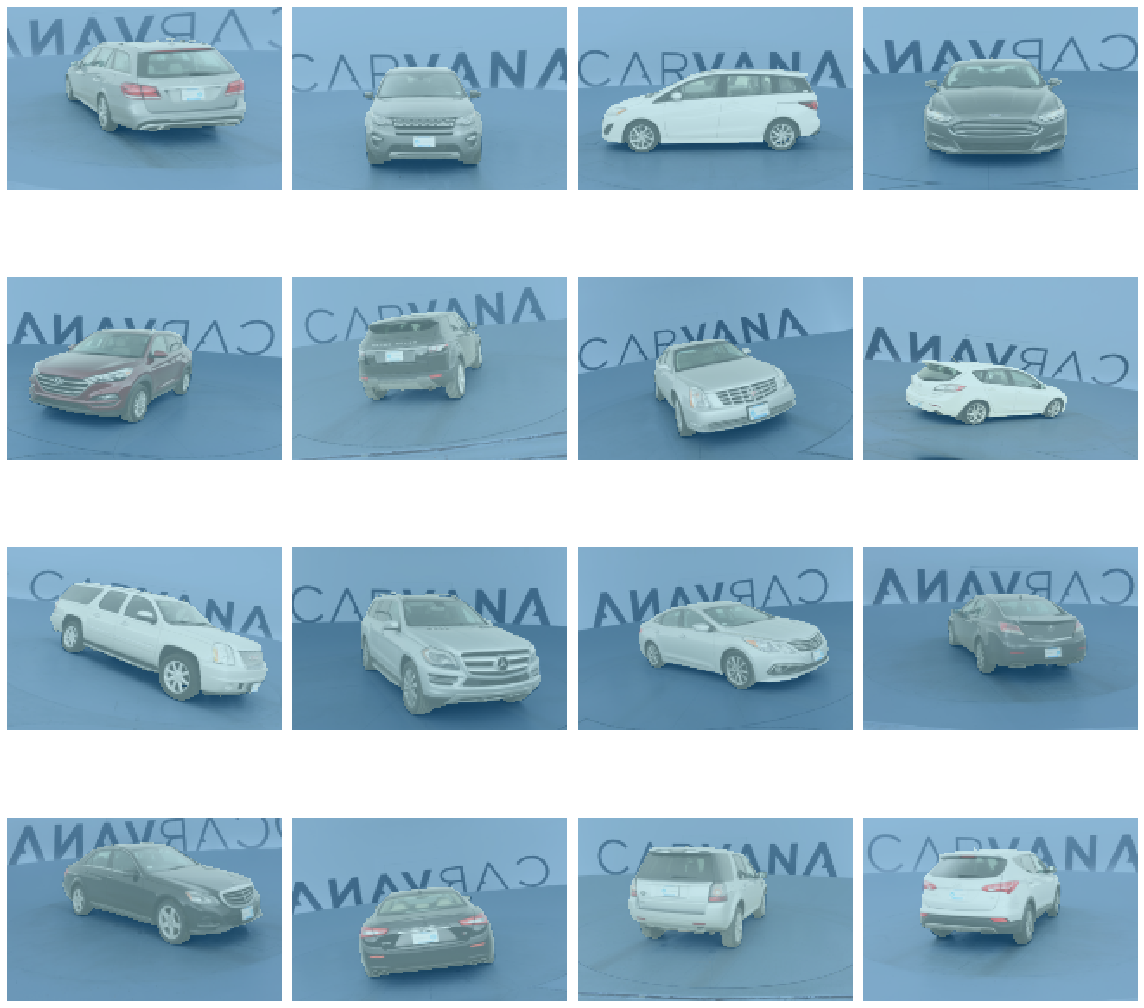

In [16]:
data.show_batch()

In [13]:
learn = unet_learner(data=data, arch=models.resnet34, metrics=[dice])

In [14]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


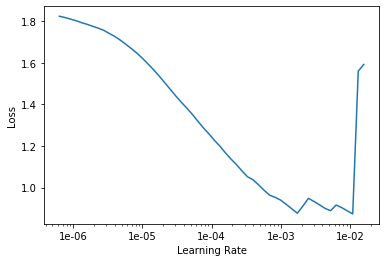

In [17]:
learn.lr_find()
learn.recorder.plot()

In [17]:
lr = 1e-5
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,dice,time
0,788.234558,1234.846313,0.514202,04:00


In [18]:
learn.save('all-stage-1-12')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


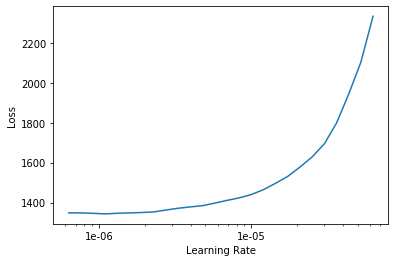

In [19]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(2, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,dice,time


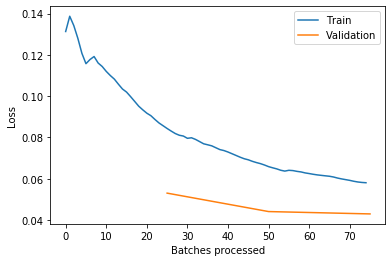

In [21]:
learn.recorder.plot_losses()

In [22]:
mname = 'stage-1-6'

In [23]:
learn.save(mname)

In [15]:
learn.load(mname)

Learner(data=ImageDataBunch;

Train: LabelList (400 items)
x: SegmentationItemList
Image (3, 213, 319),Image (3, 213, 319),Image (3, 213, 319),Image (3, 213, 319),Image (3, 213, 319)
y: SegmentationLabelList
ImageSegment (1, 213, 319),ImageSegment (1, 213, 319),ImageSegment (1, 213, 319),ImageSegment (1, 213, 319),ImageSegment (1, 213, 319)
Path: /home/lgvaz/projects/vision/carvana-cars/data/train/tiny;

Valid: LabelList (100 items)
x: SegmentationItemList
Image (3, 213, 319),Image (3, 213, 319),Image (3, 213, 319),Image (3, 213, 319),Image (3, 213, 319)
y: SegmentationLabelList
ImageSegment (1, 213, 319),ImageSegment (1, 213, 319),ImageSegment (1, 213, 319),ImageSegment (1, 213, 319),ImageSegment (1, 213, 319)
Path: /home/lgvaz/projects/vision/carvana-cars/data/train/tiny;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1

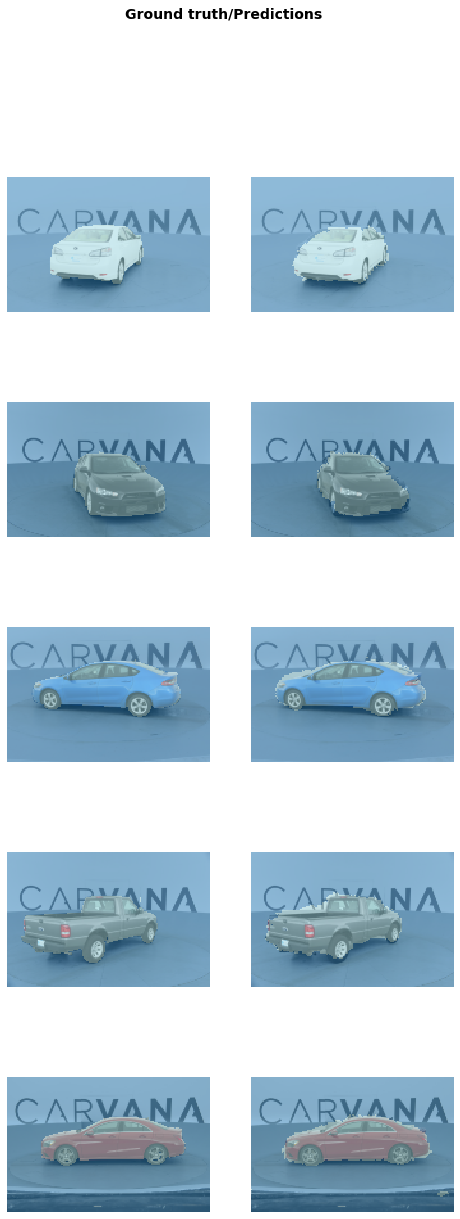

In [29]:
learn.show_results()